# Recurrent Neural Networks

In this tutorial, we will explore Recurrent Neural Networks (RNN). In this Tutorial, we will create a character-level language model that will generate text similar to Shakespeare’s works. For this purpose, we will use the `tiny Shakespeare` data set that is prepared by `Andrej Karpaty` for its blog post [The Unreasonable Effectiveness of Recurrent Neural Networks]( http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In previous tutorials, we used `torchtext` to process the data and create batches. In this tutorial, we will create our own function for processing the data and creating batches

Let’s start by importing the required libraries.

This lab is prepared with torch text version 0.10 .

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

#Recap on LSTM


Before we continue on the example, let's recap on LSTM and PyTorch function on RNN architecture. 

PyTorch has few [different RNN](https://pytorch.org/docs/stable/nn.html#recurrent-layers) approaches. mainly Cell and multilayer methods. The cell method created a single cell for that method. For example, [nn.LSTMCell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html#torch.nn.LSTMCell) creates a single LSTM block. On the other hand [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) creates an LSTM architecture with a single or multiple layers.

As mentioned previously, we will be using the LSTM model lets start with the `nn.LSTM` function. Let's go over its parameters first;
*	input_size: This is the size of inputs. i-In our case it will be equal to embedding size.
*	hidden_size:  it is the size of the hidden state h. (it is also equal to the size of the cell state c)
*	num_layers: It is the depth of the LSTM(i.e. stacked LSTM). Its default is 1. 
*	bias: Whether the layers have biases or not. Its default is True.
*	batch_first: Similar to other functions in PyTorch/TorchText if it is true it orders input and outputs as batch, seq, feature. its default is false
*	dropout: If it is not zero, dropout is applied to the end of each layer e***xcept the last one***. its default is 0
*	bidirectional: If set true, changes architecture to Bidirectional LSTM. its default is False

In [ ]:
rnn = nn.LSTM(10, 20, 2) #input_size,hidden_size,num_layers
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)  #num_layers, batch_size,hidden_size
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

As you can see from the above example we have an embedding size of 10 hidden sizes of 20 and 2 layer LSTM architecture. The hidden layer (cell state) is a three-dimensional tensor with dimensions equal to num_layers, batch_size, and hidden size. An while calling the LSTM layer we will feed our input and hidden states to our function. Please note that for the LSTM layer you need to convert hidden and cell stated as a tuple.

PyTorch formulation of an LSTM cell as follows;

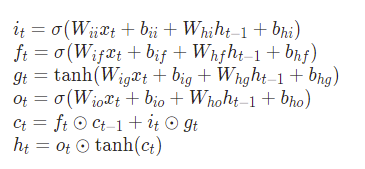


Let's try to visualize this information. Before we start here is a graph for overall LSTM architecture.

![1_mcHP77YF63SuqUGAIiBBsA[1].jpeg](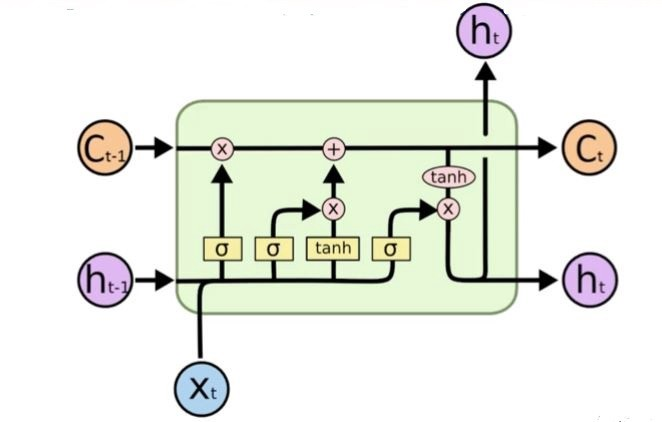)

image taken from [https://medium.datadriveninvestor.com/time-series-predictions-with-lstm-4877c38d87d1](https://medium.datadriveninvestor.com/time-series-predictions-with-lstm-4877c38d87d1)

Most of our calculation contains therm W<sub>i</sub>*x<sub>t</sub>+b<sub>i</sub>+W<sub>h</sub>*h<sub>t-1</sub>+b<sub>h</sub> which is similar to 2 linear layers summed to each other which is visualized in the following image. After this, each layer used activation functions (either sigmoid or tanh) to finish their steps. Please note that every cell its own weights.

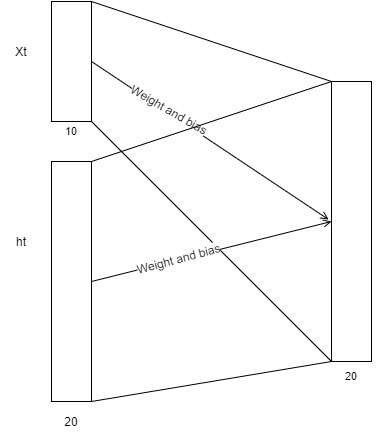

Calculating a new cell state  c<sub>t</sub> is straightforward. First, we multiply the previous cell state c<sub>t-1</sub> with our forget gate f<sub>t</sub> elementwise. Then we add input gate i<sub>t</sub> multiplied by new cell content g<sub>t</sub> elementwise.

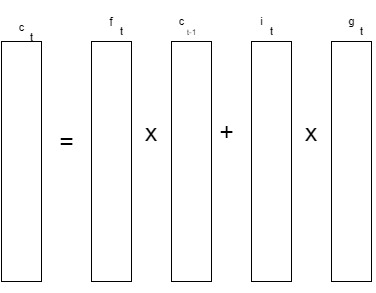

Lastly, we will calculate the new hidden state h<sub>t</sub>.  After finding tanh of the new cell state  tanh(c<sub>t</sub>) state we will multiply it with the output gate  o<sub>t</sub> to obtain our new hidden state.

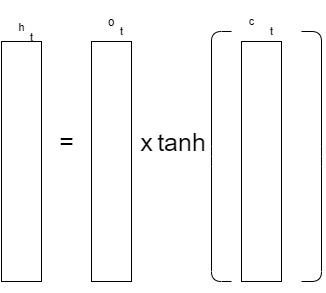

## Loading Data

Lets start getting our data In case you are using Google Colab you may want to install `input.text` to your drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#This is where I kept my file in drive. I entered the folder using `%cd` command for ease of access
%cd /content/gdrive/MyDrive/Colab\ Notebooks/dlprj

/content/gdrive/MyDrive/Colab Notebooks/dlprj


In [ ]:
#You can also pull the data from this GitHub link if you want. https://github.com/karpathy/char-rnn/tree/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()

## Data preparation

We will be creating a character-level language model. Firstly we need easy access to characters. Luckily because our data is a string (i.e.. char-array), so we can easily access characters from text.

In [ ]:
print("\033[1m"+'First 100 characters:\n'+"\033[0m",text[:100])  # In chararray
print("\033[1m"+'\n3891st character:\n'+"\033[0m", text[3891]) 

First 100 characters:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

3891st character:
 v


Again, due to the nature of the character-level language model, we don’t need any tokenization and so on. We only need to create our vocabulary and dictionaries to convert character to int and int to character.

In [ ]:
chars = tuple(set(text))    #get characters present
int2char = dict(enumerate(chars))   #dictinonary for int to character conversion
char2int = {ch: i for i, ch in int2char.items()} #dictinonary for character to int conversion

text_as_int = np.array([char2int[ch] for ch in text])  #convert all text
print('Length of the vocabulary: ', len(chars))
print("Character 'a' is" ,char2int['a'],"and char 'A' is ", char2int['A'])
print("\033[1m"+'First 100 characters as int :\n'+"\033[0m",text_as_int[:100])  #show first 100 characters

Length of the vocabulary:  65
Character 'a' is 21 and char 'A' is  34
First 100 characters as int :
 [51 46 45 37 33 36 53 46 33 46 59 50 63 20 44  2 50 13  4 45 50 36 38 50
 36 56 45  4 30 50 50 18 36 21 63 22 36 13 29 45 33 58 50 45  1 36 58 50
 21 45 36 24 50 36 37 56 50 21 12 28 44 44 34  7  7 20 44 55 56 50 21 12
  1 36 37 56 50 21 12 28 44 44 51 46 45 37 33 36 53 46 33 46 59 50 63 20
 44 16  4 29]


Because we have such a small vocabulary, instead of using embeddings, we can easily use it on hot vectors with size 65.

In [ ]:
def one_hot_encode(int_array , u_char):  #input array of ints and char vocbulary 
    
    one_hot = np.zeros((np.multiply(*int_array.shape), u_char), dtype=np.float32)  #create empty array
    one_hot[np.arange(one_hot.shape[0]), int_array.flatten()] = 1.  #set appropiate column as 1
    one_hot = one_hot.reshape((*int_array.shape, u_char))
    return one_hot

In [ ]:
one_hot_encode(np.array([[1],[2]]),5)

array([[[0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.]]], dtype=float32)

<img src='http://karpathy.github.io/assets/rnn/charseq.jpeg' width='350'>


Now that we have a way of creating one-hot vectors, we need to create our batches. Because we are going to train an RNN network Our output needs to be one shifted version of the inputs. For example, while our input is 'hell our output needs to be ‘ello’.

Because our input data is plain text, in addition to our batch size we need to determine how many characters we need to put in each batch.


In [ ]:
def batch_create(arr, batch_size, char_num):  #arr is data, char_num is character number at a data point and batch size is number of data point contained in a batch
    batch_size_total = batch_size * char_num
    n_batches = len(arr)//batch_size_total
    
    arr = arr[:n_batches * batch_size_total] #remove extra chracters from data

    arr = arr.reshape((batch_size, -1)) #convert to batch sizes
    
    for n in range(0, arr.shape[1], char_num): # we need to create output  and input data by shifting them
        input_data = arr[:, n:n+char_num]
        output_data = np.zeros_like(input_data)
        try:
            output_data[:, :-1], output_data[:, -1] = input_data[:, 1:], arr[:, n+char_num]
        except IndexError:
            output_data[:, :-1], output_data[:, -1] = input_data[:, 1:], arr[:, 0]
        yield input_data, output_data

In [ ]:
next(batch_create(text_as_int,4,4))

(array([[51, 46, 45, 37],
        [36, 58,  4, 38],
        [50, 36, 13,  7],
        [ 7,  7, 36,  4]]), array([[46, 45, 37, 33],
        [58,  4, 38, 36],
        [36, 13,  7, 21],
        [ 7, 36,  4, 63]]))

# Network

PyTorch neural network module ([torch.nn ]( https://pytorch.org/docs/stable/nn.html#recurrent-layers)) provides easy access to RNN architectures. It provides both a single cell and multi-layer architecture with multiple layers.
In this example, we will use `torch.nn.LSTM` which is a multi-layer LSTM module.


In [ ]:
class CharLSTM(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2, lr=0.001):
        super().__init__()
        self.n_layers = n_layers     #lets put the parameters inside of the function for ease of access and when we save our networks parameters will stay with it.
        self.n_hidden = n_hidden
        self.lr = lr
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=0.5, batch_first=True)  #lstm layer with 0.5 dropout
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(n_hidden, len(self.chars)) # linear layer to calculate
      
    
    def forward(self, x, hidden):              
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden) #convert to 1 dimension   
        out = self.fc(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size): #creates hidden layer parameters.
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
              weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())

        return hidden

# Training

Now that our network is ready lets start training our network

In [ ]:
n_hidden=512
n_layers=2
net = CharLSTM(chars, n_hidden, n_layers).cuda()
print(net)

CharLSTM(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)


In [ ]:
opt = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from time import time
start = time()
batch_size = 128
seq_length = 100
epochs = 20
net.train()

val_idx = int(len(text_as_int)*(0.9)) #select %90/10 split
data, val_data = text_as_int[:val_idx], text_as_int[val_idx:]


counter = 0
n_chars = len(net.chars)
for e in range(epochs):
    h = net.init_hidden(batch_size)
    
    for x, y in batch_create(data, batch_size, seq_length):
        counter += 1  #counter for printing
        
        x = one_hot_encode(x, n_chars)    #encode the data
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
        inputs, targets = inputs.cuda(), targets.cuda()

        h = tuple([each.data for each in h]) #creating new h for new batch to prevent backprobation for all h
        
        net.zero_grad()
        output, h = net(inputs, h)
        loss = loss_fn(output, targets.view(batch_size*seq_length).long())
        loss.backward()

        nn.utils.clip_grad_norm_(net.parameters(), 5)  #clip at parameters higher than 5 for preventing exploding gradient problem
        opt.step()
        
        if counter % 50 == 0: #print every 50 step
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x, y in batch_create(val_data, batch_size, seq_length):
                x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                val_h = tuple([each.data for each in val_h]) #creating new h for new batch to prevent backprobation for all h
                
                inputs, targets = x.cuda(), y.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = loss_fn(output, targets.view(batch_size*seq_length).long())
            
                val_losses.append(val_loss.item())
            
            net.train() # reset to train mode after iterationg through validation data
            
            print(f'Epoch: {e+1}/{epochs}... Step: {counter}... Loss: {loss.item():.4f}... Val Loss: {np.mean(val_losses):.4f}')
end=time()
cpu_time = end - start
print(f'{cpu_time:.2f} seconds')

Epoch: 1/20... Step: 50... Loss: 3.2835... Val Loss: 3.2820
Epoch: 2/20... Step: 100... Loss: 2.9733... Val Loss: 2.9309
Epoch: 2/20... Step: 150... Loss: 2.5751... Val Loss: 2.5532
Epoch: 3/20... Step: 200... Loss: 2.3498... Val Loss: 2.3093
Epoch: 4/20... Step: 250... Loss: 2.2117... Val Loss: 2.1817
Epoch: 4/20... Step: 300... Loss: 2.0962... Val Loss: 2.0886
Epoch: 5/20... Step: 350... Loss: 2.0194... Val Loss: 2.0109
Epoch: 6/20... Step: 400... Loss: 1.9652... Val Loss: 1.9447
Epoch: 6/20... Step: 450... Loss: 1.8978... Val Loss: 1.8994
Epoch: 7/20... Step: 500... Loss: 1.8319... Val Loss: 1.8550
Epoch: 8/20... Step: 550... Loss: 1.8065... Val Loss: 1.8071
Epoch: 8/20... Step: 600... Loss: 1.7479... Val Loss: 1.7805
Epoch: 9/20... Step: 650... Loss: 1.7298... Val Loss: 1.7474
Epoch: 9/20... Step: 700... Loss: 1.6681... Val Loss: 1.7210
Epoch: 10/20... Step: 750... Loss: 1.6608... Val Loss: 1.7032
Epoch: 11/20... Step: 800... Loss: 1.6416... Val Loss: 1.6792
Epoch: 11/20... Step: 8

# Saving model 

Now that our training is done, we can save our network using `torch.save()` command to use later. (If you can also integrate this command to training loop to save your model in regular intervals)

In [ ]:
# Saving the model
model_name = 'LSTM.net'
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

In [ ]:
with open(model_name, 'wb') as f:  # in this case we will save it to drive folder that we opened in begining of this tutorial.
    torch.save(checkpoint, f)

#Prediction

We created our network trained it and saved it. The last thing we need to do is creating text that is similar to Shakespeare’s works. Our problem now is when we gave the network and select the character with the highest probability, we will obtain the same output every time.

To solve this, we will apply the topk prediction approach. This method gives random probability to k words according to their weights. For example, if we want to apply using 2 characters and the highest valued characters was ‘a’ with 0.7 and ‘e’ with 0.1 using this approach random model will select ‘a’ with 87.5% probability and ‘e’ with 12.5% probability. Using the topk method when we run the code, we can obtain different results each time when we run the algorithm.


In [ ]:
def predict(net, char, h=None):  #created function for top k prediction
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x).cuda()
             
        h = tuple([each.data for each in h]) #again preventing backprobagation
        out, h = net(inputs, h)

        p = F.softmax(out, dim=1).data.cpu()  #sofmax here due to preventing softmaxing whole data

        p, top_ch = p.topk(5)   #choose 5 elements and choose add a probability choice
        top_ch = top_ch.numpy().squeeze()
        p = p.numpy().squeeze()
        output = np.random.choice(top_ch, p=p/p.sum())

        return net.int2char[output], h

In [ ]:
first_chars='A man'       
net.eval()

chars = [ch for ch in first_chars]
h = net.init_hidden(1)
for ch in first_chars:
    char, h = predict(net, ch, h)

chars.append(char)

for ii in range(500): #find next 100 characters
    char, h = predict(net, chars[-1], h)
    chars.append(char)

output= ''.join(chars)

print(output)

A man, to hear thee, and he show
In harm all to to send and the cortay
Bried the carry. Hence than all his head,
When I his pother's serves a misdrough
That should she seem the seam. Therefier I spile,
To be so minion to your fair both
And the mother as this world to me;
And the tark of the state of the mounce;
And having seess my bluss the sin is true.

GLOUCESTER:
This is the pardings with the world;
And in me from my fither trush is son
Tenter to the sick with sounds of mine.
A poisent of thy condi
